In [1]:
import vcg
import tools
import perturb_ecg
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
fs = 1024

t,y = tools.default_vcg_solve(60, fs=fs, duration=10)

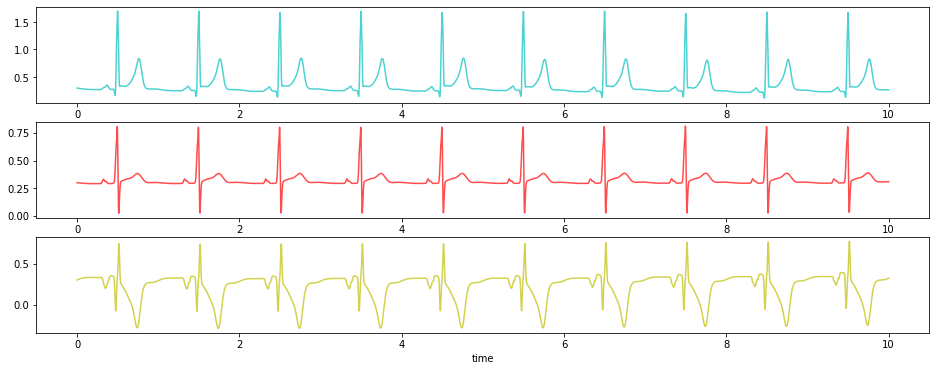

In [3]:
fig, axs = plt.subplots(3,1, figsize=[16,6])
axs[0].plot(t,y[:,0], 'c', alpha=0.7)
axs[1].plot(t,y[:,1], 'r', alpha=0.7)
axs[2].plot(t,y[:,2], 'y', alpha=0.7)

for ax in axs :
    ax.set_xlabel('time')

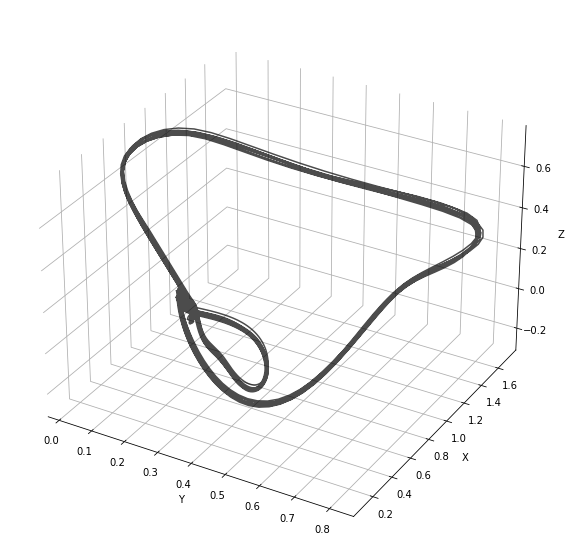

In [4]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes(projection='3d')
ax.plot3D(y[:,1], y[:,0], y[:,2], 'k', alpha=0.7)
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.grid(True);
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w');

In [5]:
e = tools.convert_vcg_to_12lead(y)

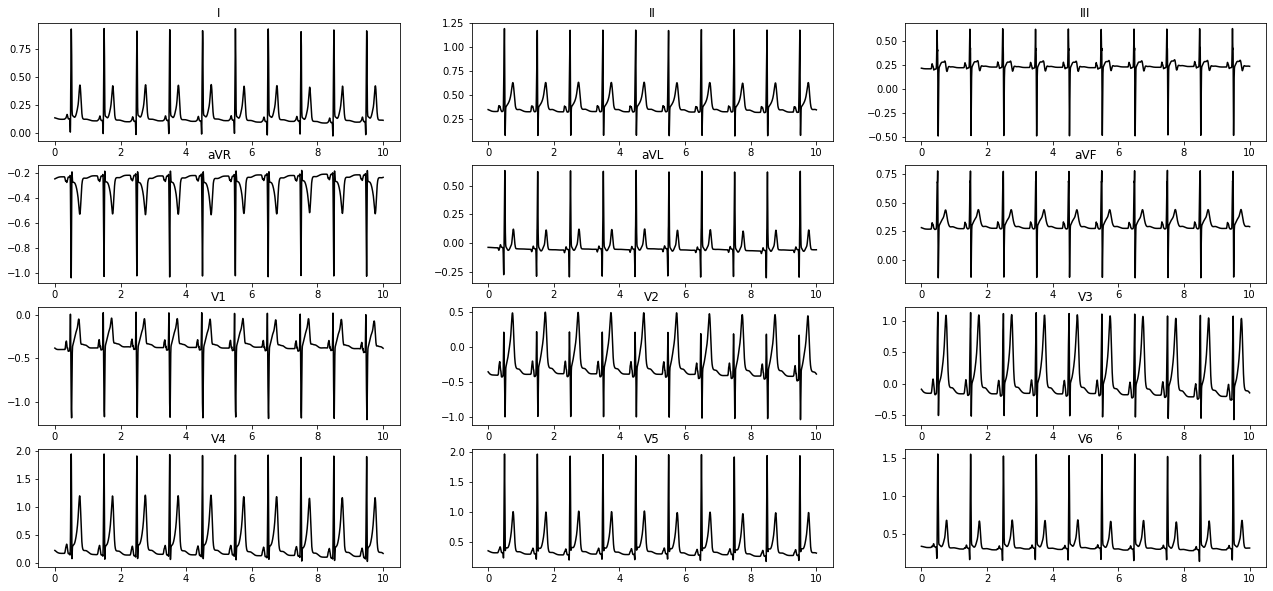

In [6]:
fig, axs = plt.subplots(4,3, figsize=[22,10])

axs_f = axs.flatten()

idx = 0
for lead in tools.Dower_lead_map :
    
    axs_f[idx].plot(t, e[:,tools.Dower_lead_map[lead]], 'k')
    axs_f[idx].set_title(lead)
    #axs_f[idx].set_xlabel('time (s)')
    
    idx += 1

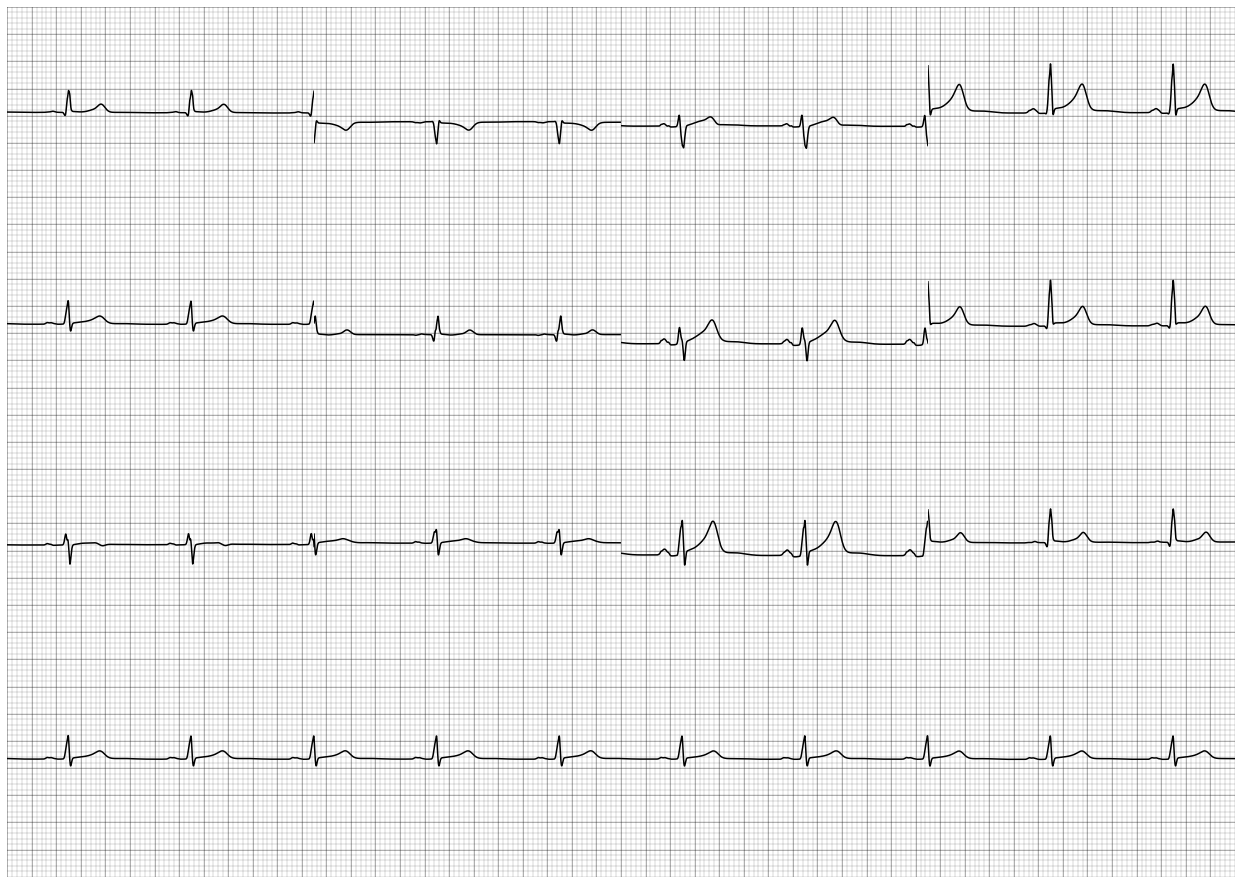

In [7]:
tools.plot12(e, fs=fs, n_squares=8)

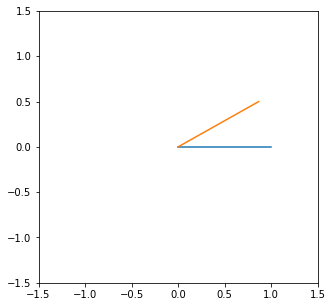

In [8]:
# rotation

plt.figure(figsize=[5,5])
v1 = np.array([1,0,0])
plt.plot([0,v1[0]], [0,v1[1]])
v2 = tools.Rz(30) @ v1
plt.plot([0,v2[0]], [0,v2[1]])
plt.axis([-1.5,1.5,-1.5,1.5]);

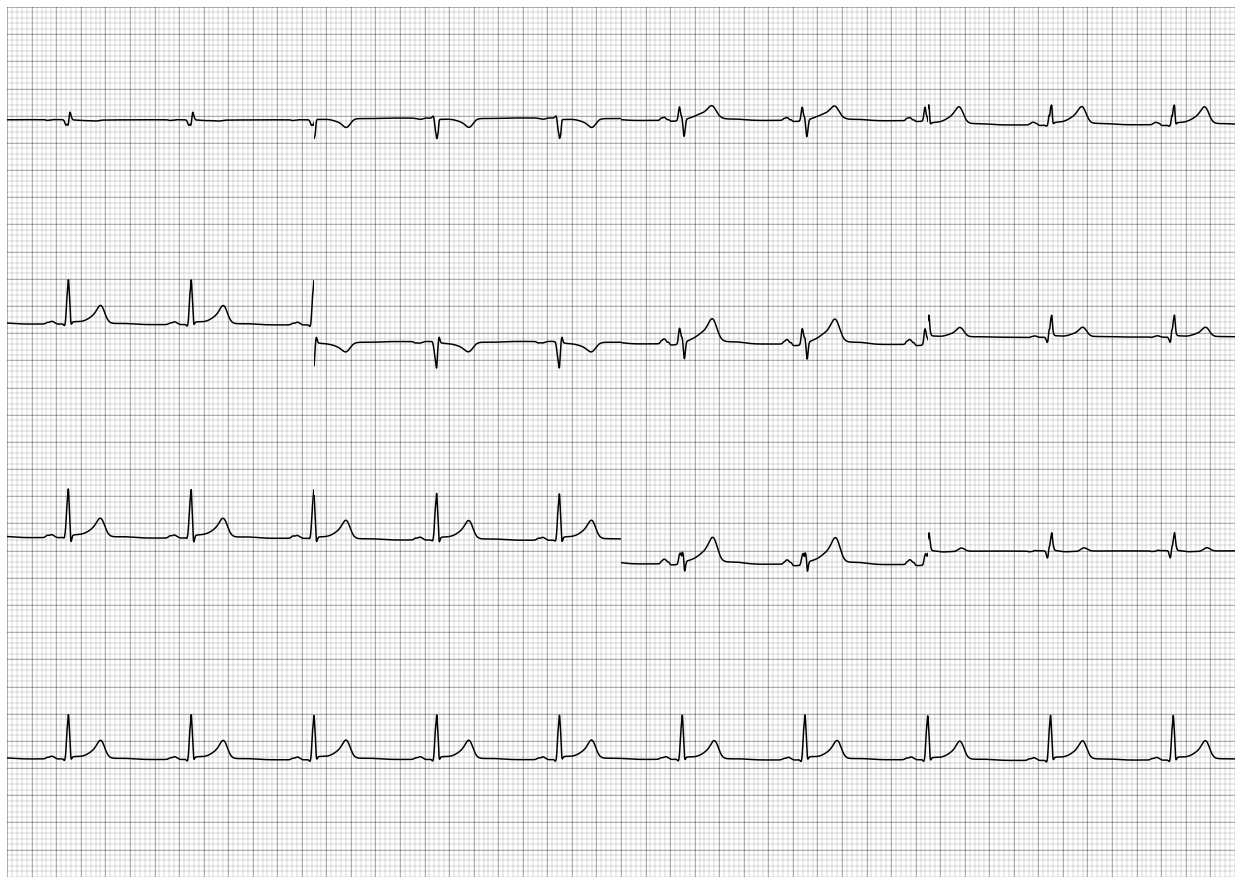

In [9]:
vcg_rotate = tools.rotate_vcg(y, th_z=60)
ecg_rotate = tools.convert_vcg_to_12lead(vcg_rotate)
tools.plot12(ecg_rotate, fs=1024)

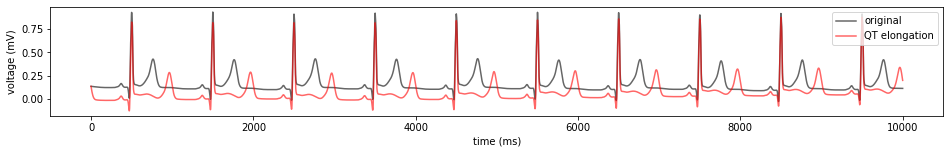

In [10]:
# QT elongation

vcg_ode = vcg.VCG(60)

t1, y1 = tools.solve_vcg_object(vcg_ode, duration=10)

vcg_ode2 = perturb_ecg.qt_elongation(vcg_ode, ms_forward=200)

t2, y2 = tools.solve_vcg_object(vcg_ode2, duration=10)

del vcg_ode
del vcg_ode2

e1 = tools.convert_vcg_to_12lead(y1)
e2 = tools.convert_vcg_to_12lead(y2)

plt.figure(figsize=[16,2])
plt.plot(t1*1000, e1[:,0], 'k', alpha=0.6, label='original')
plt.plot(t2*1000, e2[:,0], 'r', alpha=0.6, label='QT elongation')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)');
plt.legend();

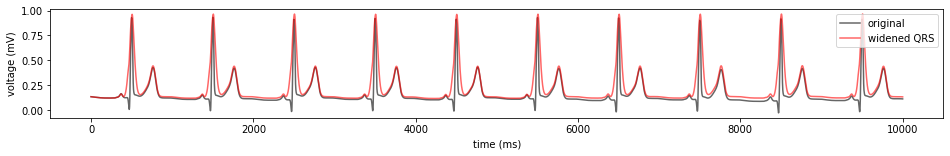

In [11]:
# wide QRS

vcg_ode = vcg.VCG(60)

t1, y1 = tools.solve_vcg_object(vcg_ode, duration=10)

vcg_ode2 = perturb_ecg.wide_qrs(vcg_ode, percent_widened=500, scaledown=0.5)

t2, y2 = tools.solve_vcg_object(vcg_ode2, duration=10)

del vcg_ode
del vcg_ode2

e1 = tools.convert_vcg_to_12lead(y1)
e2 = tools.convert_vcg_to_12lead(y2)

plt.figure(figsize=[16,2])
plt.plot(t1*1000, e1[:,0], 'k', alpha=0.6, label='original')
plt.plot(t2*1000, e2[:,0], 'r', alpha=0.6, label='widened QRS')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)');
plt.legend();

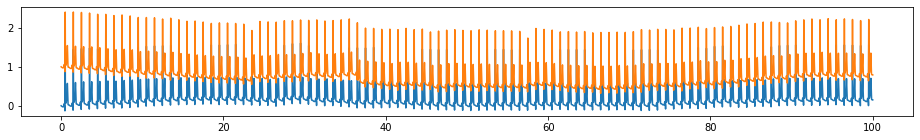

In [12]:
# do initial conditions matter?
# Yes

vcg_ode = vcg.VCG(60)
v0 = np.array([0,0,0,0])
t1, y1 = tools.solve_vcg_object(vcg_ode, v0=v0, duration=100)

vcg_ode = vcg.VCG(60)
v0 = np.array([0,1,1,1])
t2, y2 = tools.solve_vcg_object(vcg_ode, v0=v0, duration=100)

plt.figure(figsize=[16,2])
plt.plot(t1, y1[:,0])
plt.plot(t2, y2[:,0])

In [13]:
# developing the noise tool...

out = perturb_ecg.band_limited_noise([512*10,12], .1, 100)
out2 = perturb_ecg.band_limited_noise([512*10,12], 10, 100)

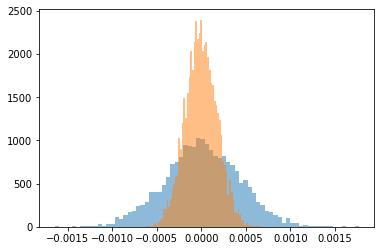

In [14]:
plt.hist(out[:,0], bins=int(np.sqrt(5120)), alpha=0.5, density=True);
plt.hist(out2[:,0], bins=int(np.sqrt(5120)), alpha=0.5, density=True);

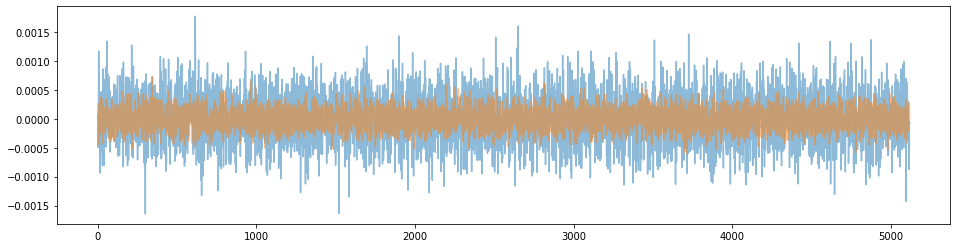

In [15]:
plt.figure(figsize=[16,4])
plt.plot(out[:,0], alpha=0.5)
plt.plot(out2[:,0], alpha=0.5)

In [16]:
high_amps = []

for i in range(10) :
    out = perturb_ecg.band_limited_noise([512*10,12], .1, 10 + i*10)
    
    high_amps.append(np.mean(np.sort(np.abs(out[:,0])[-512:])))

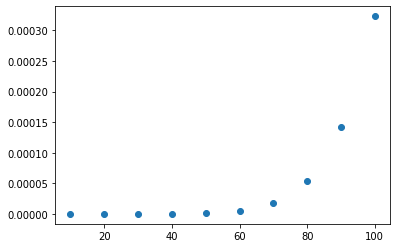

In [17]:
plt.figure()

plt.plot([10+i*10 for i in range(10)], high_amps, 'o')

In [18]:
np.mean(out, axis=0)

array([ 8.07326117e-06,  9.54178103e-05,  5.17563652e-04,  1.69361044e-03,
        3.66552054e-03,  5.29203244e-03,  4.48528030e-03,  2.63870449e-04,
       -5.10843384e-03, -6.95116806e-03, -2.41436691e-03,  5.86855341e-03])

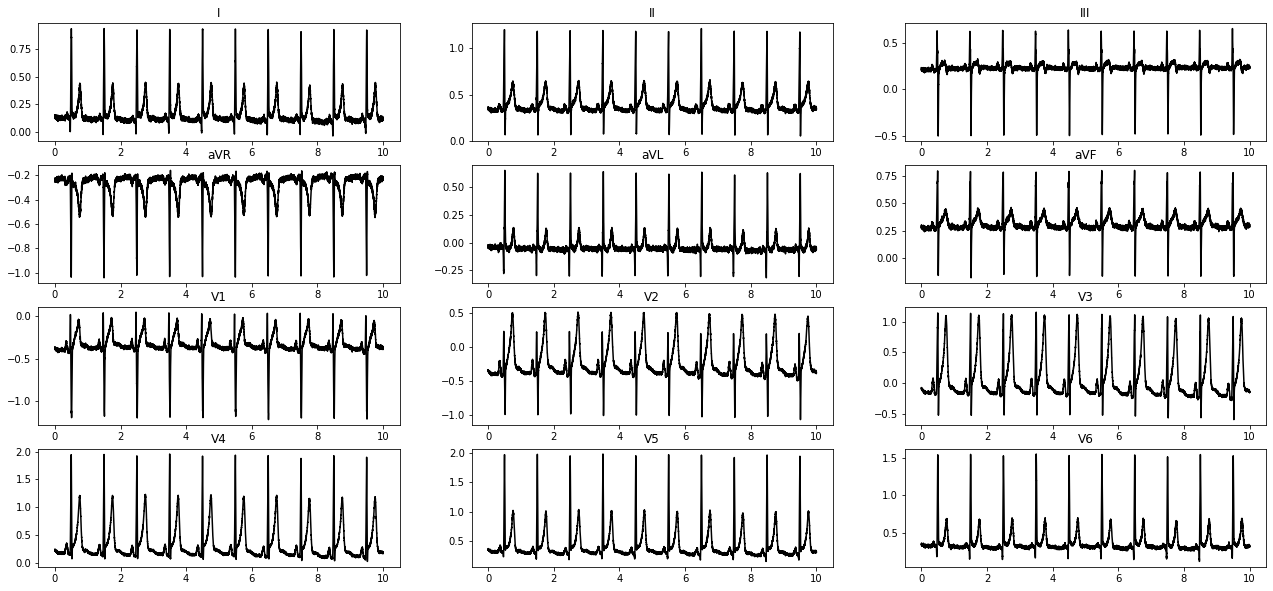

In [25]:
# starting with a fresh, simple ecg
t,y = tools.default_vcg_solve(60, fs=fs, duration=10)
e = tools.convert_vcg_to_12lead(y)

e_noisy = perturb_ecg.add_noise(e, 50, 60, .01, fs=fs)

fig, axs = plt.subplots(4,3, figsize=[22,10])

axs_f = axs.flatten()

idx = 0
for lead in tools.Dower_lead_map :
    
    axs_f[idx].plot(t, e_noisy[:,tools.Dower_lead_map[lead]], 'k')
    axs_f[idx].set_title(lead)
    #axs_f[idx].set_xlabel('time (s)')
    
    idx += 1

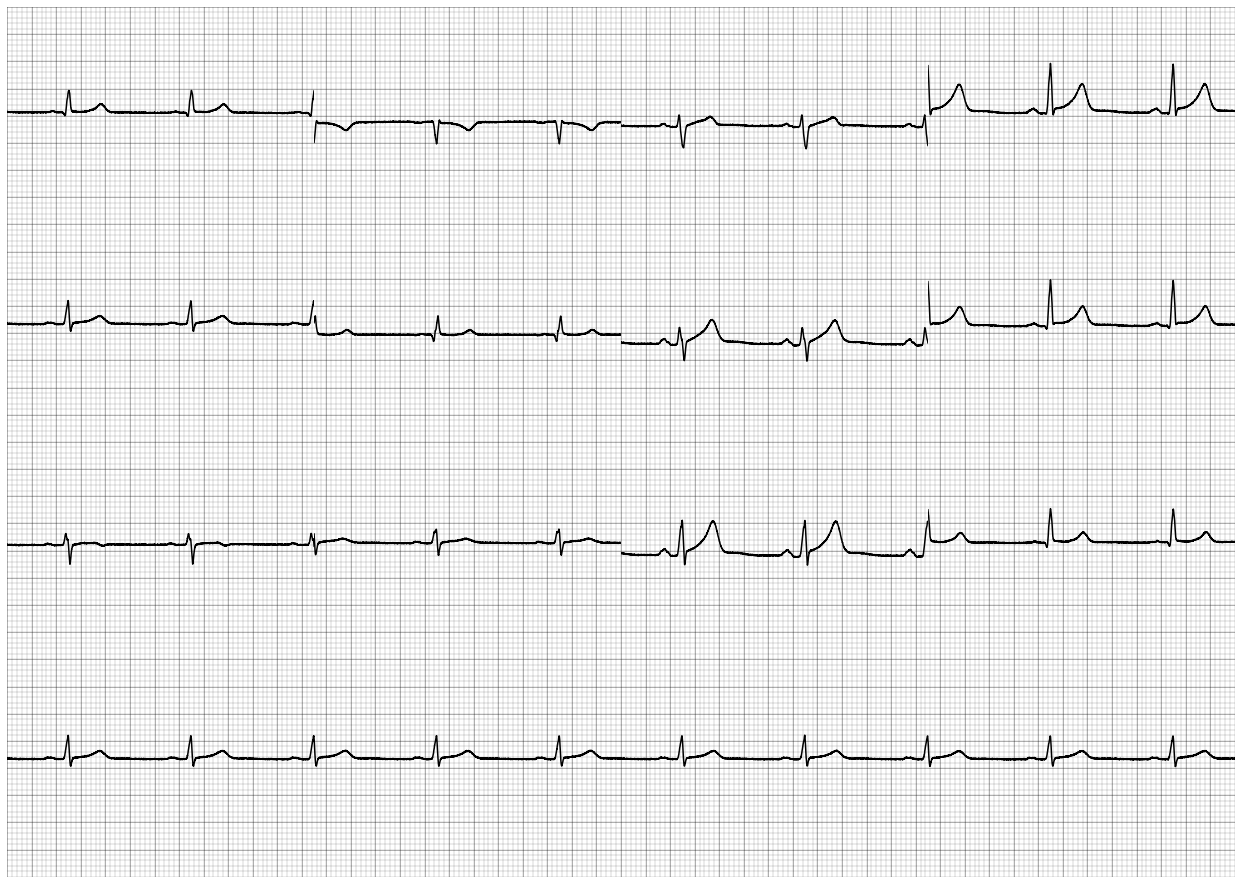

In [26]:
tools.plot12(e_noisy, fs=fs)